# 03. PyTorch Computer Vision

Computer vision is the art of teaching a computer to see.

For example, it could involve building a model to classify whether a photo is of a cat or a dog (binary classification).

Or whether a photo is of a cat, dog or chicken (multi-class classification).

Or identifying where a car appears in a video frame (object detection).

Or figuring out where different objects in an image can be separated (panoptic segmentation).

### Computer vision libraries in PyTorch
Before we get started writing code, let's talk about some PyTorch computer vision libraries you should be aware of.

| PyTorch module | What does it do? |
|----------------| ---------------- |
| torchvision | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| torchvision.datasets | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets. |
| torchvision.models |  This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. |
| torchvision.transforms | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. |
| torch.utils.data.Dataset | Base dataset class for PyTorch. |
| torch.utils.data.DataLoader | Creates a Python iteralbe over a dataset (created with torch.utils.data.Dataset) |


>  **Note:** The `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes aren't only for computer vision in PyTorch, they are capable of dealing with many different types of data.

let's import the relevant dependencies.

In [20]:
# Import PyTorch
import torch
from torch import nn

# Import torchvisioin
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\n torchvision.__version__")

PyTorch version: 2.0.1+cu118
 torchvision.__version__


### 1. Getting a dataset
We are using FashionMNIST dataset. it contains grayscale images of 10 different kinds of clothing.

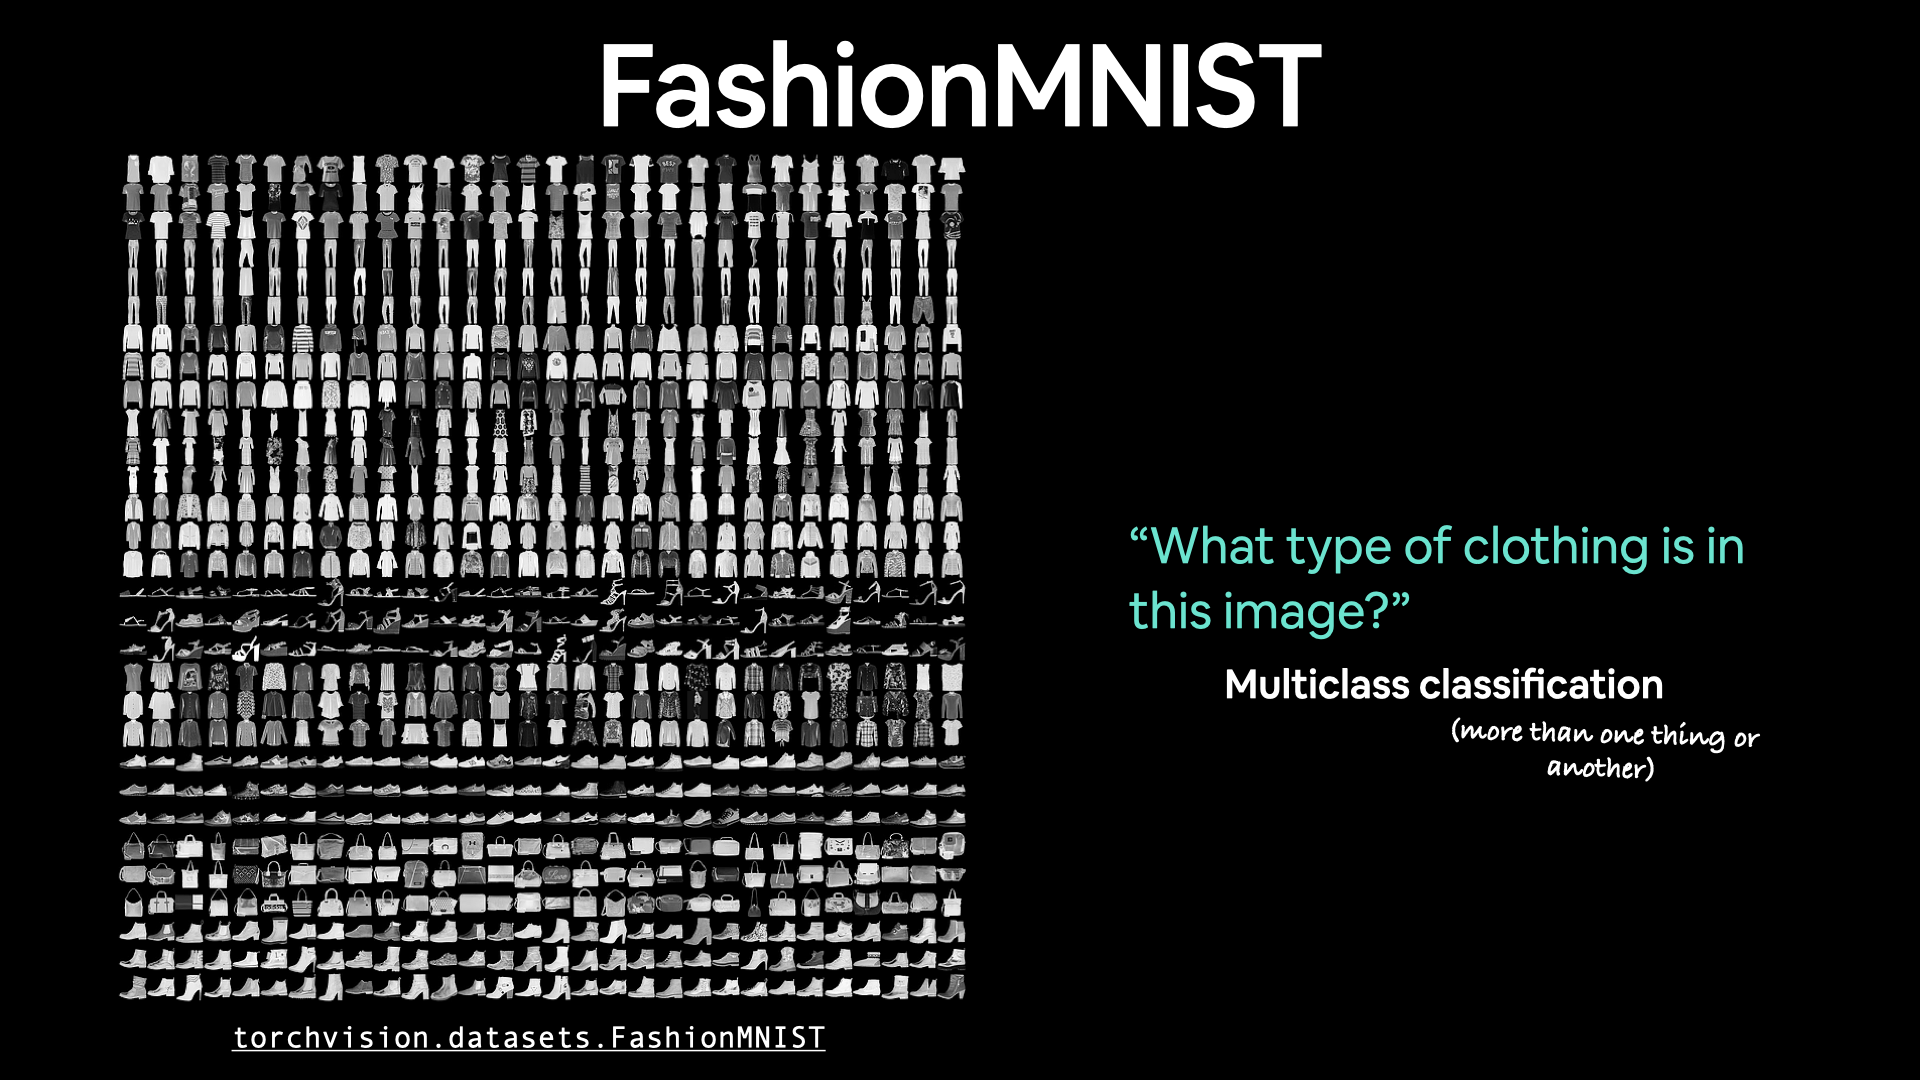

`torchvision.datasets` contains a lot of example datasets you can use to practice writing computer vision code on

In [21]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)


Let's check out the first sample of the training data.

In [22]:
# See training sample
image, label = train_data[0]
# image, label

### 1.1 Input and output shapes of a computer vision model

We've got a big tensor of values (the image) leading to a single value for the target (the label).

In [23]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

[color_channels=1, height=28, width=28]

Having` color_channels=1` means the image is grayscale.

If `color_channels=3`, the image comes in pixel values for red, green and blue (this is also known a the **RGB color model**).

>  **Note:** You'll also see `NCHW` and `NHWC` formats where `N` stands for number of images. For example if you have a `batch_size=32`, your tensor shape may be `[32, 1, 28, 28]`. We'll cover batch sizes later.

PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

However, PyTorch also explains that `NHWC` (channels last) performs better and is considered best practice.



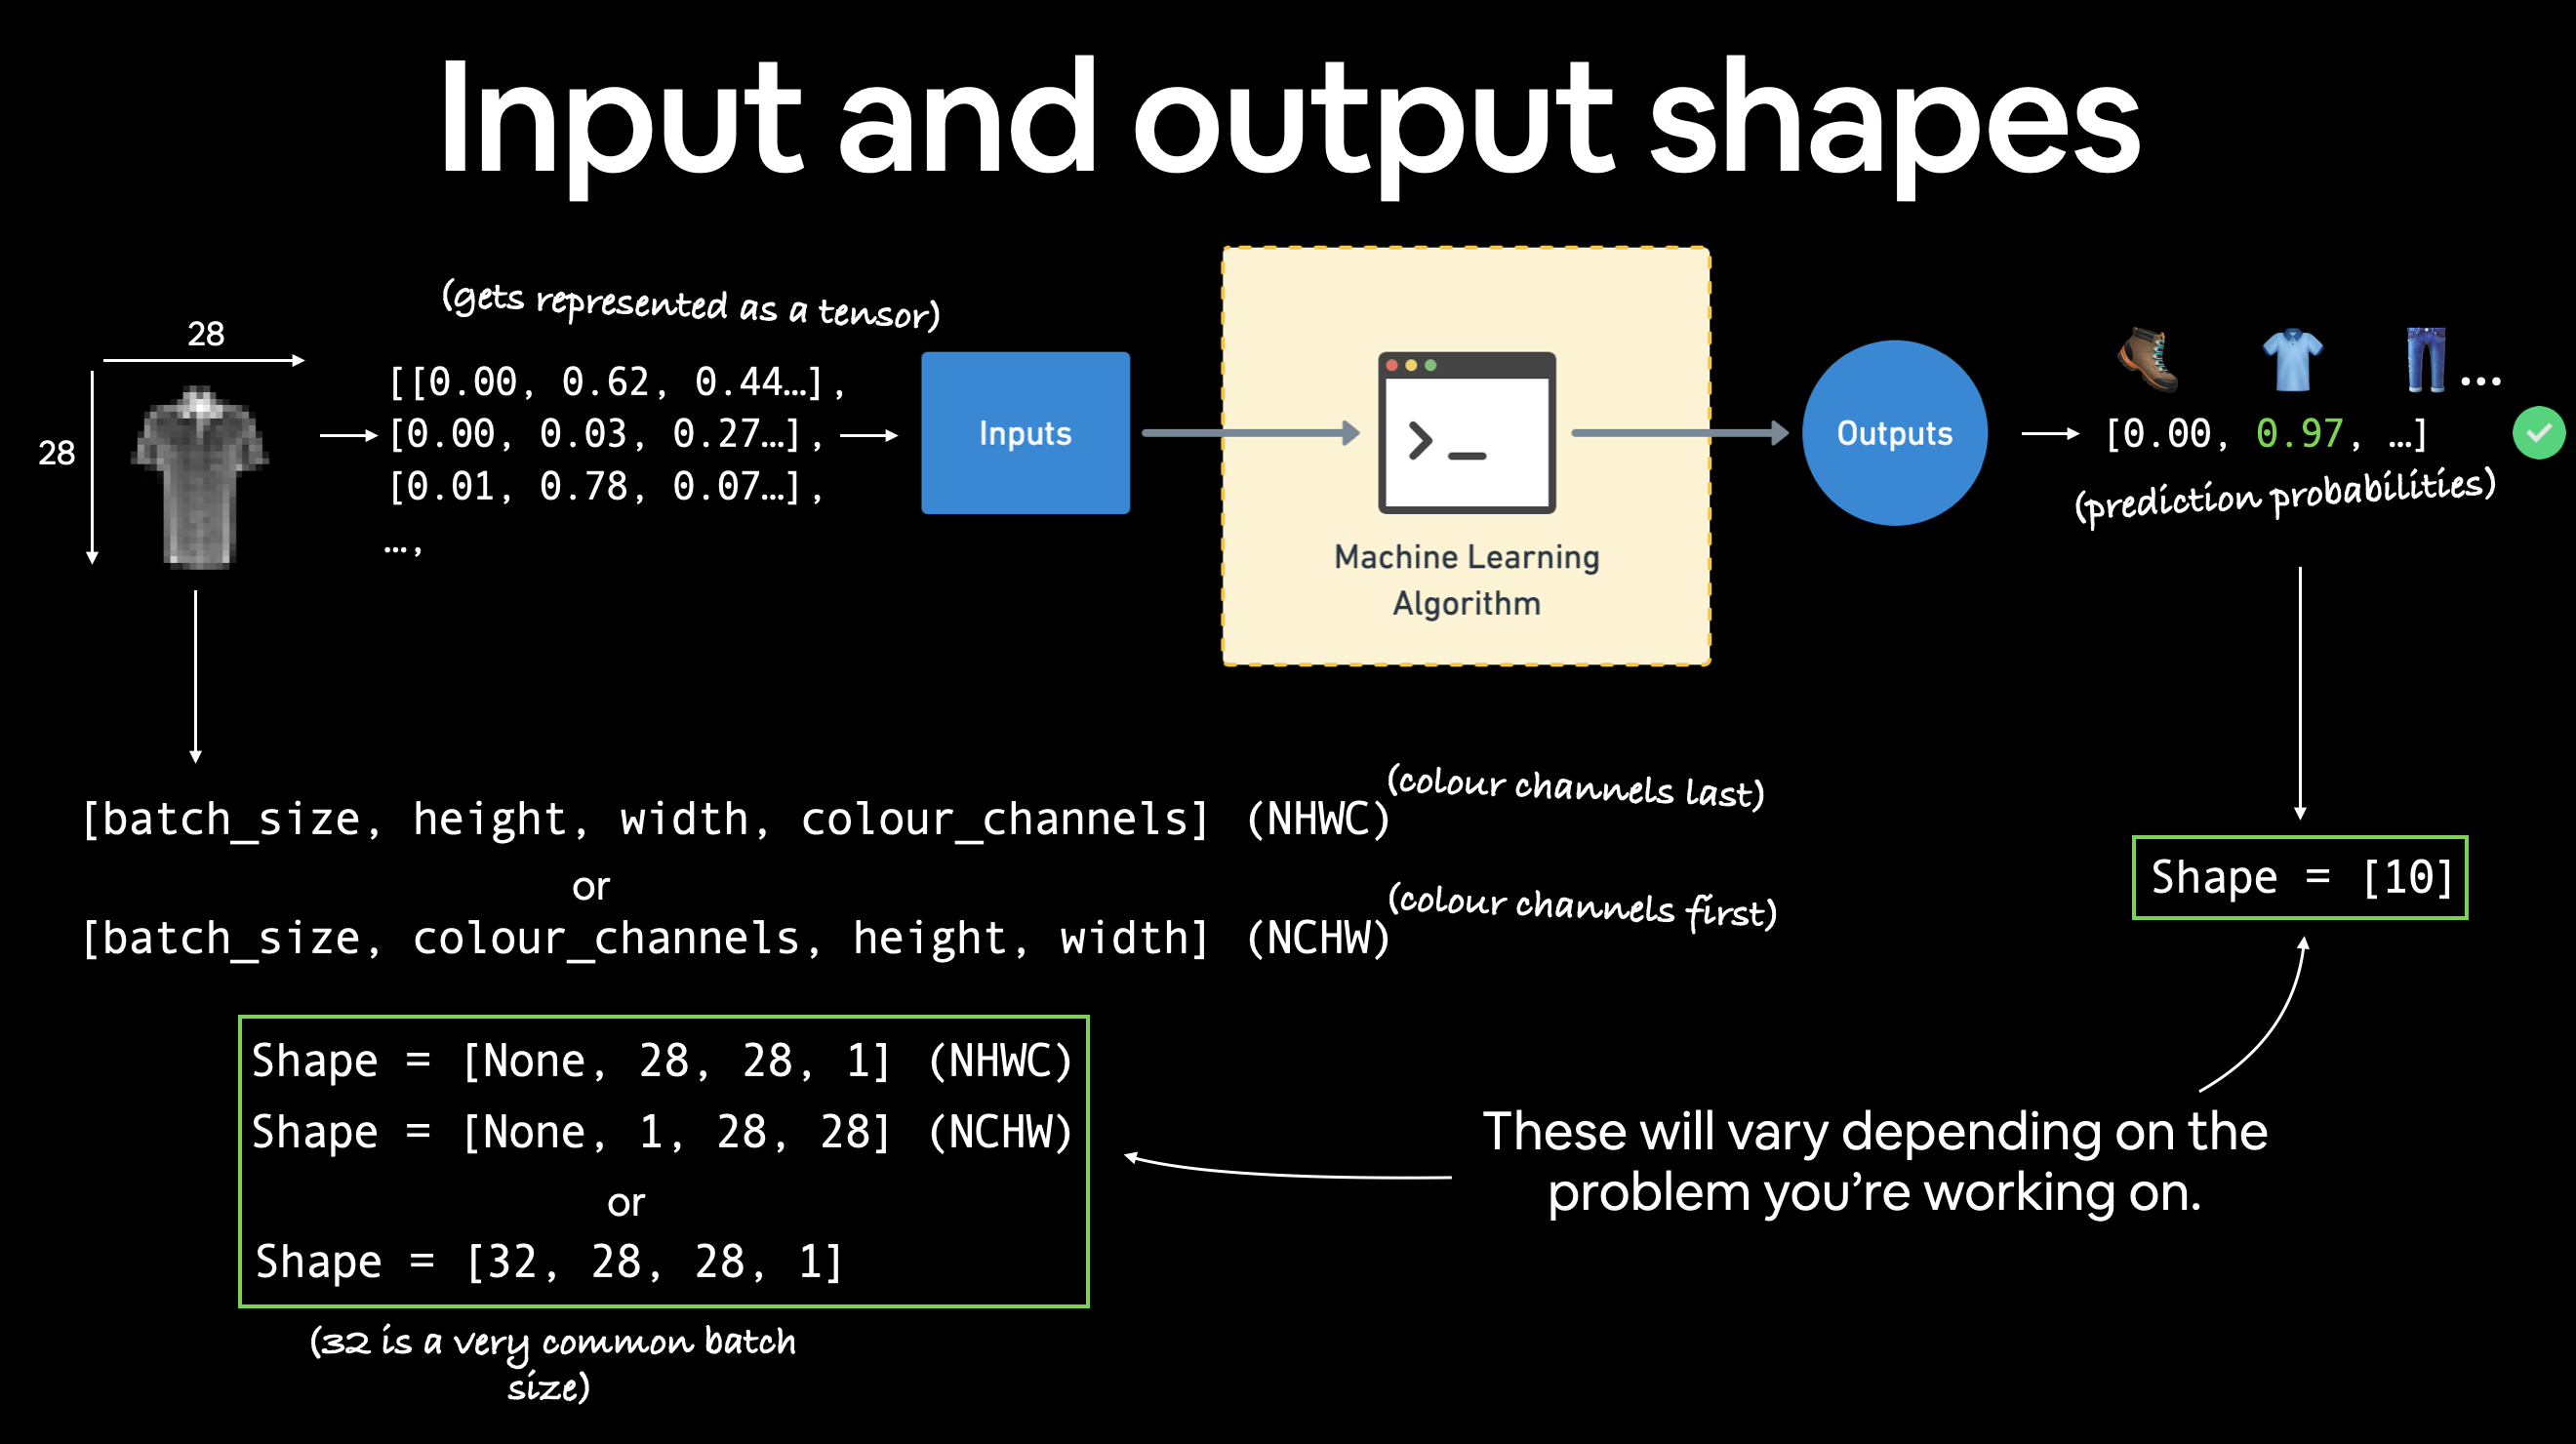

Let's check out more shapes of our data.

In [24]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

What classes are there? We can find these via the `.classes` attribute.

In [25]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

we're working with 10 different classes, it means our problem is **multi-class classification**.

### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

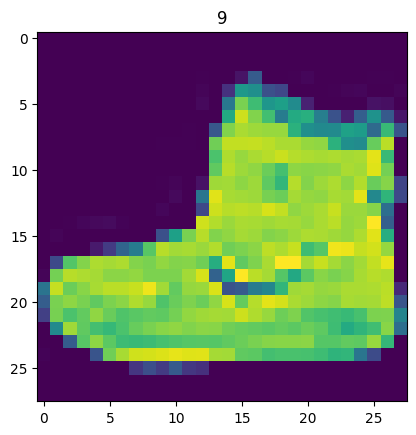

In [26]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())   # image shape is [1, 28, 28] (color channel, height, width)
plt.title(label)

We can turn the image into grayscale using the cmap parameter of plt.imshow().

Text(0.5, 1.0, 'Ankle boot')

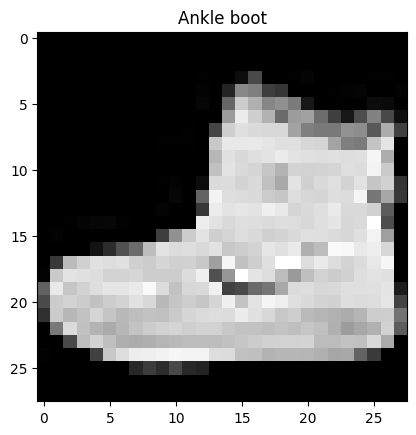

In [27]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

Let's view a few more.

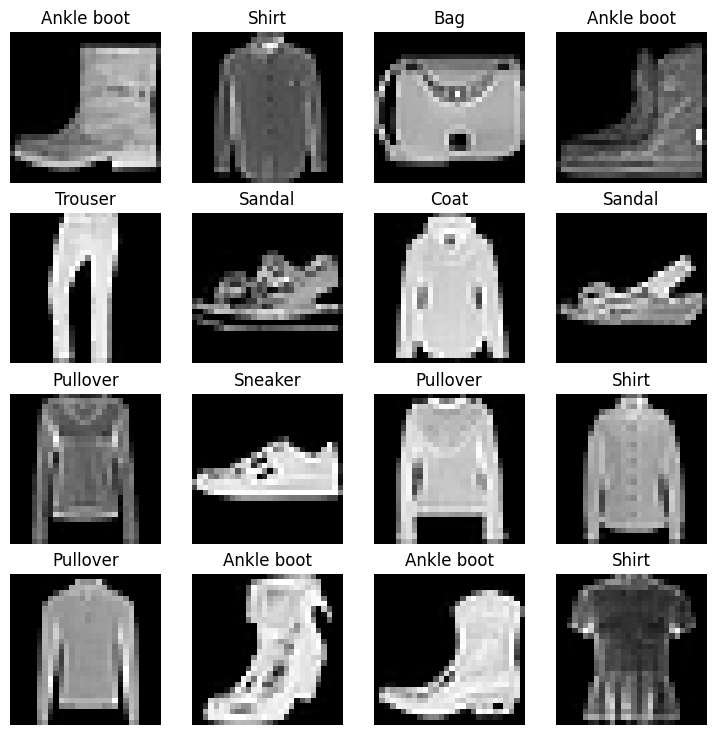

In [28]:
# Plot more imges
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)


### 2. Prepare DataLoader
Now we've got a dataset ready to go.

The next step is to prepare it with a `torch.utils.data.DataLoader` or `DataLoader` for short.


It helps load data into a model for training and for inference.

It turns a large **Dataset** into a Python iterable of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

Why do this?

Because it's more computationally efficient.

In an ideal world you could do the forward pass and backward pass across all of your data at once.

But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

It also gives your model more opportunities to improve.

With **mini-batches** (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

**32 is a good place to start** for a fair amount of problems.

But since this is a value you can set (a **hyperparameter**) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

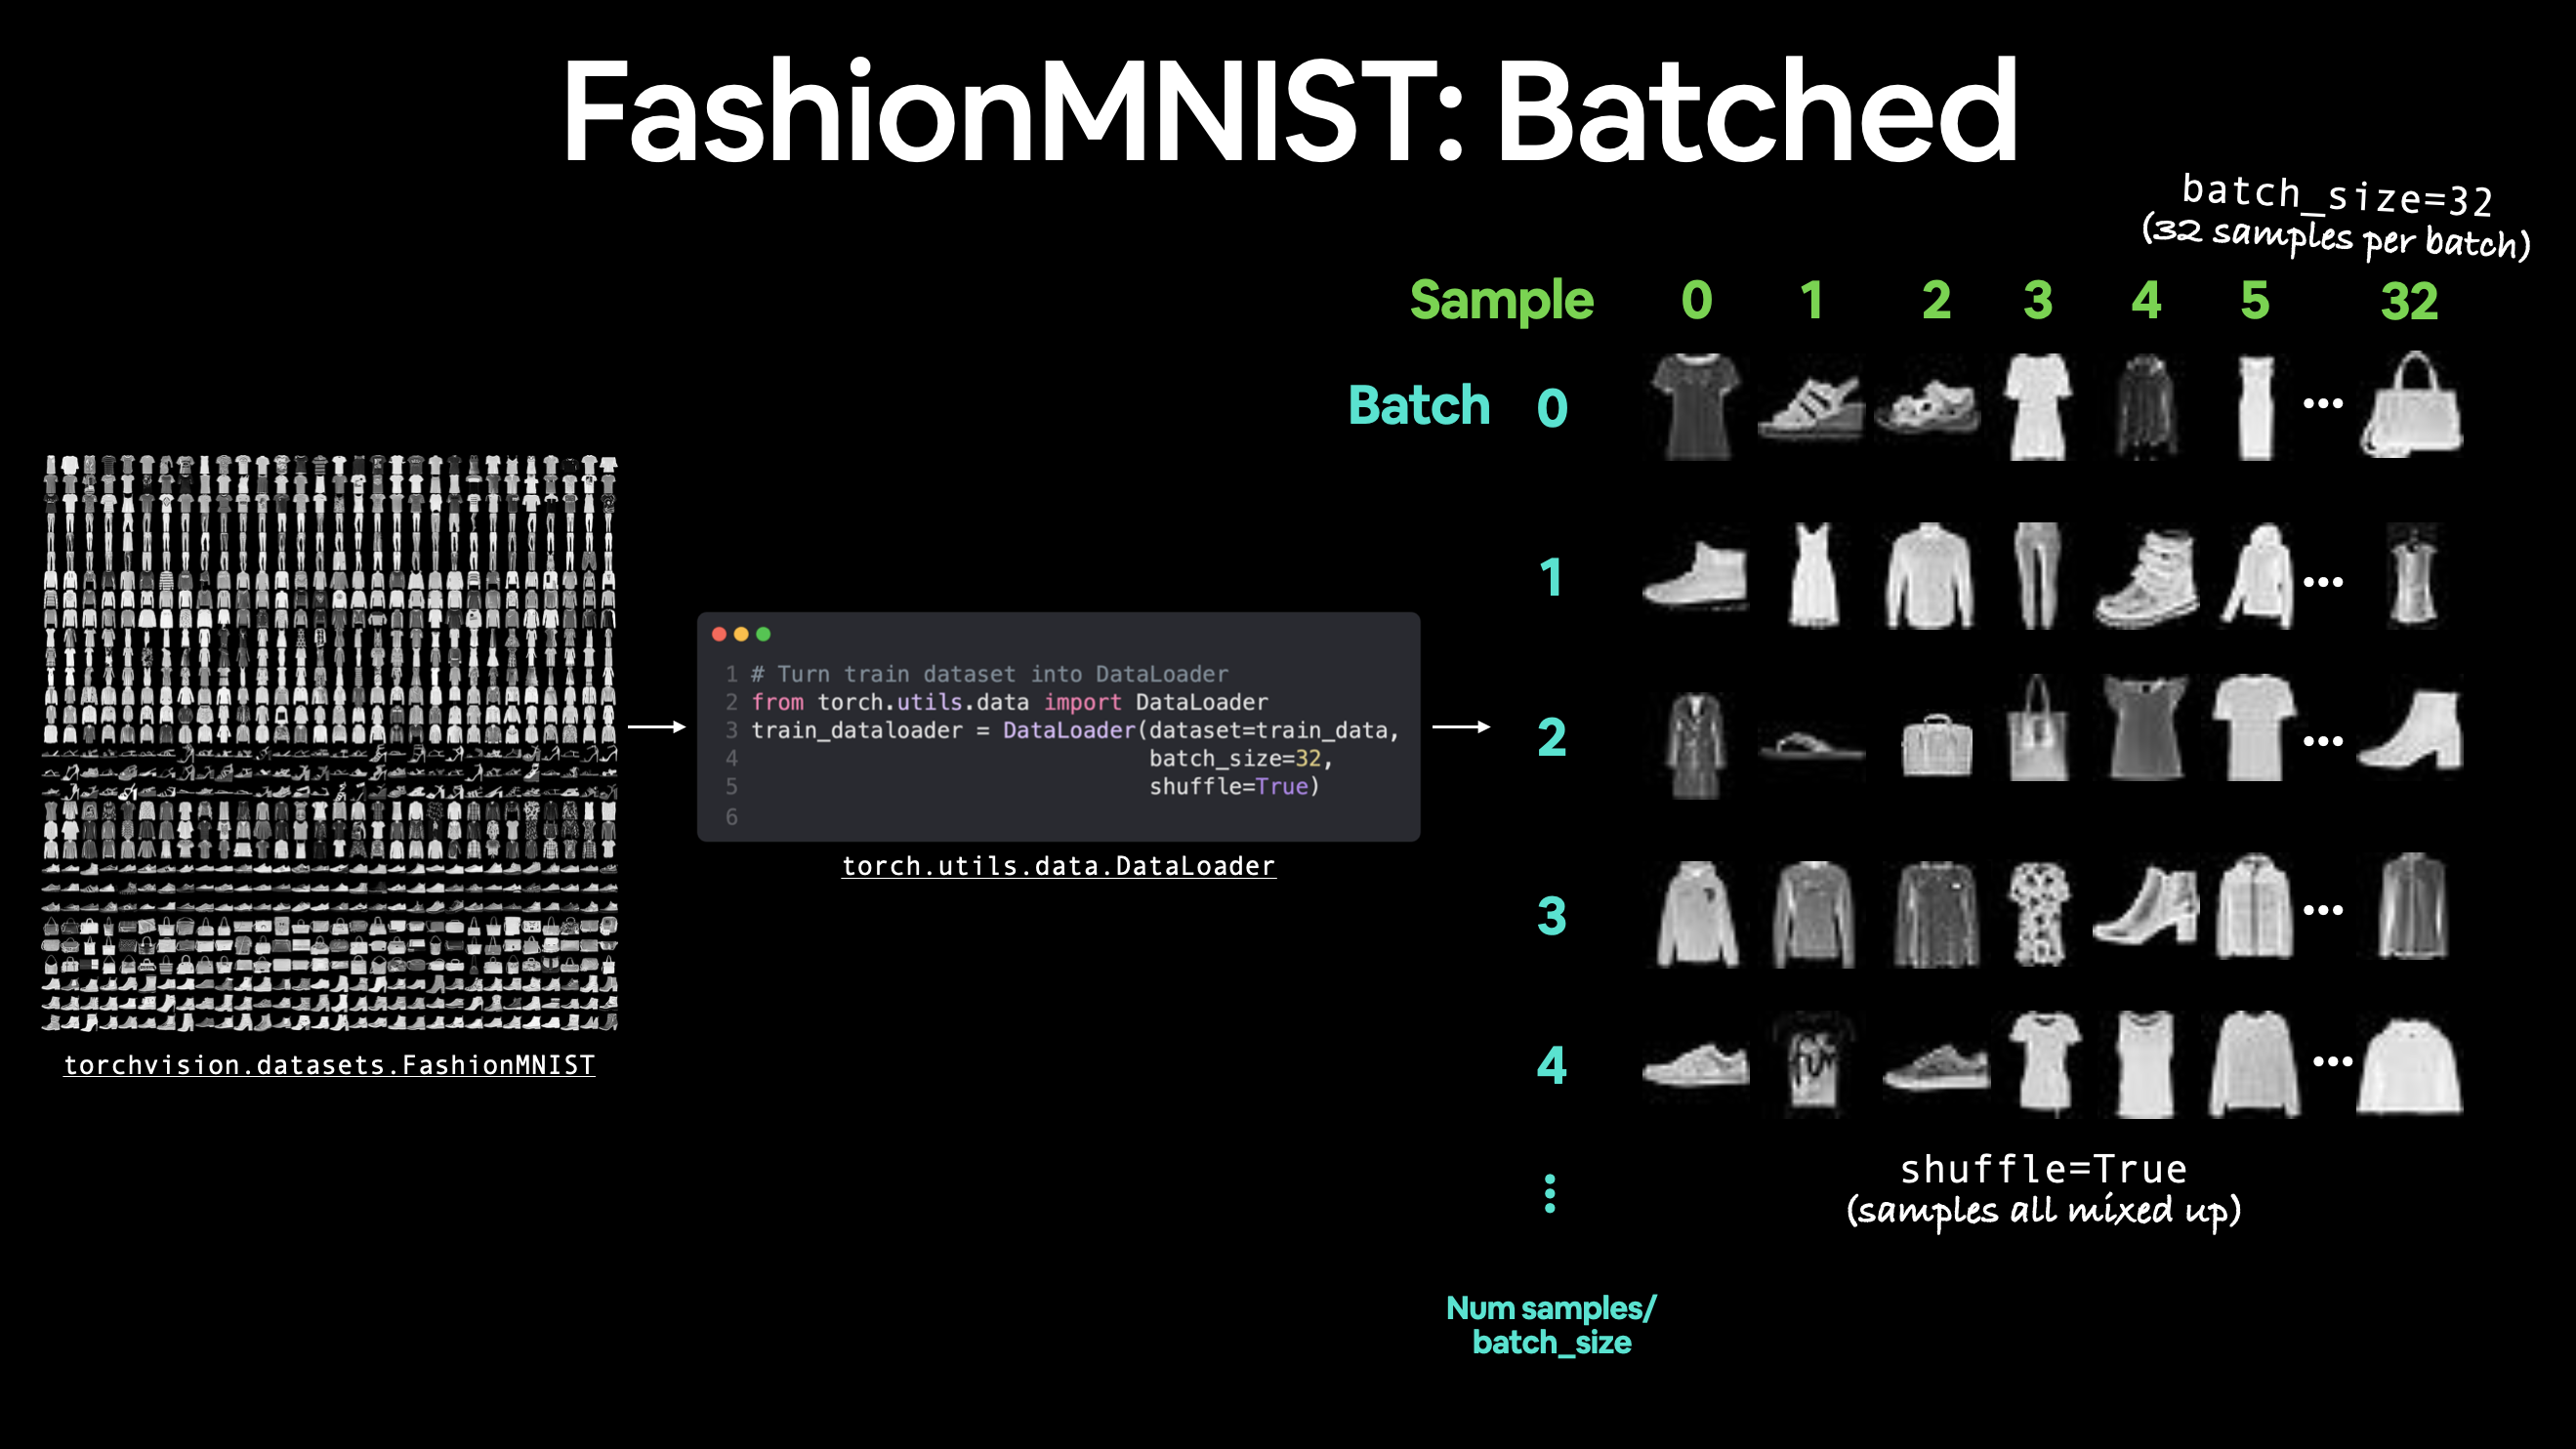

Batching FashionMNIST with a batch size of 32 and shuffle turned on. A similar batching process will occur for other datasets but will differ depending on the batch size.

In [29]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,    # dataset to turn into iterable
           batch_size=BATCH_SIZE,   # how many sample per batch?
           shuffle=True    # shuffle data every epoch?
           )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle = False    # don't necessarily have to shuffle the testing data
                             )

# let's check out what we have created
print(f"Dataloader: {train_dataloader, test_dataloader}")
print(f"Lenght of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Lenght of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x7905c85875e0>, <torch.utils.data.dataloader.DataLoader object at 0x7905c8584cd0>)
Lenght of train dataloader: 1875 batches of 32
Lenght of test dataloader: 313 batches of 32


In [30]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))


And we can see that the data remains unchanged by checking a single sample.

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


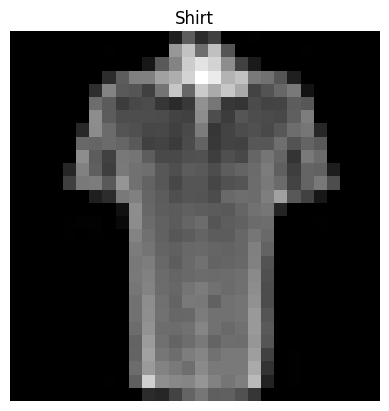

In [31]:
# Show the sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### 3. Setup device agnostic-code (for using a GPU if there is one)


In [32]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 7. Model 2: Building a Convolutional Neural Network (CNN)

 Convolutional Neural Network (CNN or ConvNet) find patterns in visual data.

 It follows the typical structure of a convolutional neural network:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

Where the contents of `[Convolutional layer -> activation layer -> pooling layer]` can be upscaled and repeated multiple times, depending on requirements.

### What model should I use?
This table is a good general guide for which model to use (though there are exceptions).

| Problem type | Model to use (generally) | Code example |
|----------------|------------------|---------------------|
| Structured data (Excel spreadsheets, row and column data) | Gradient boosted models, Random Forests, XGBoost | [sklearn.ensemble](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), [XGBoost library](https://) |
| Unstructured data (images, audio, language) | Convolutional Neural Networks, Transformers | [torchvision.models ](https://pytorch.org/vision/stable/models.html), [HuggingFace](https://) |


let's build a CNN that replicates the model on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

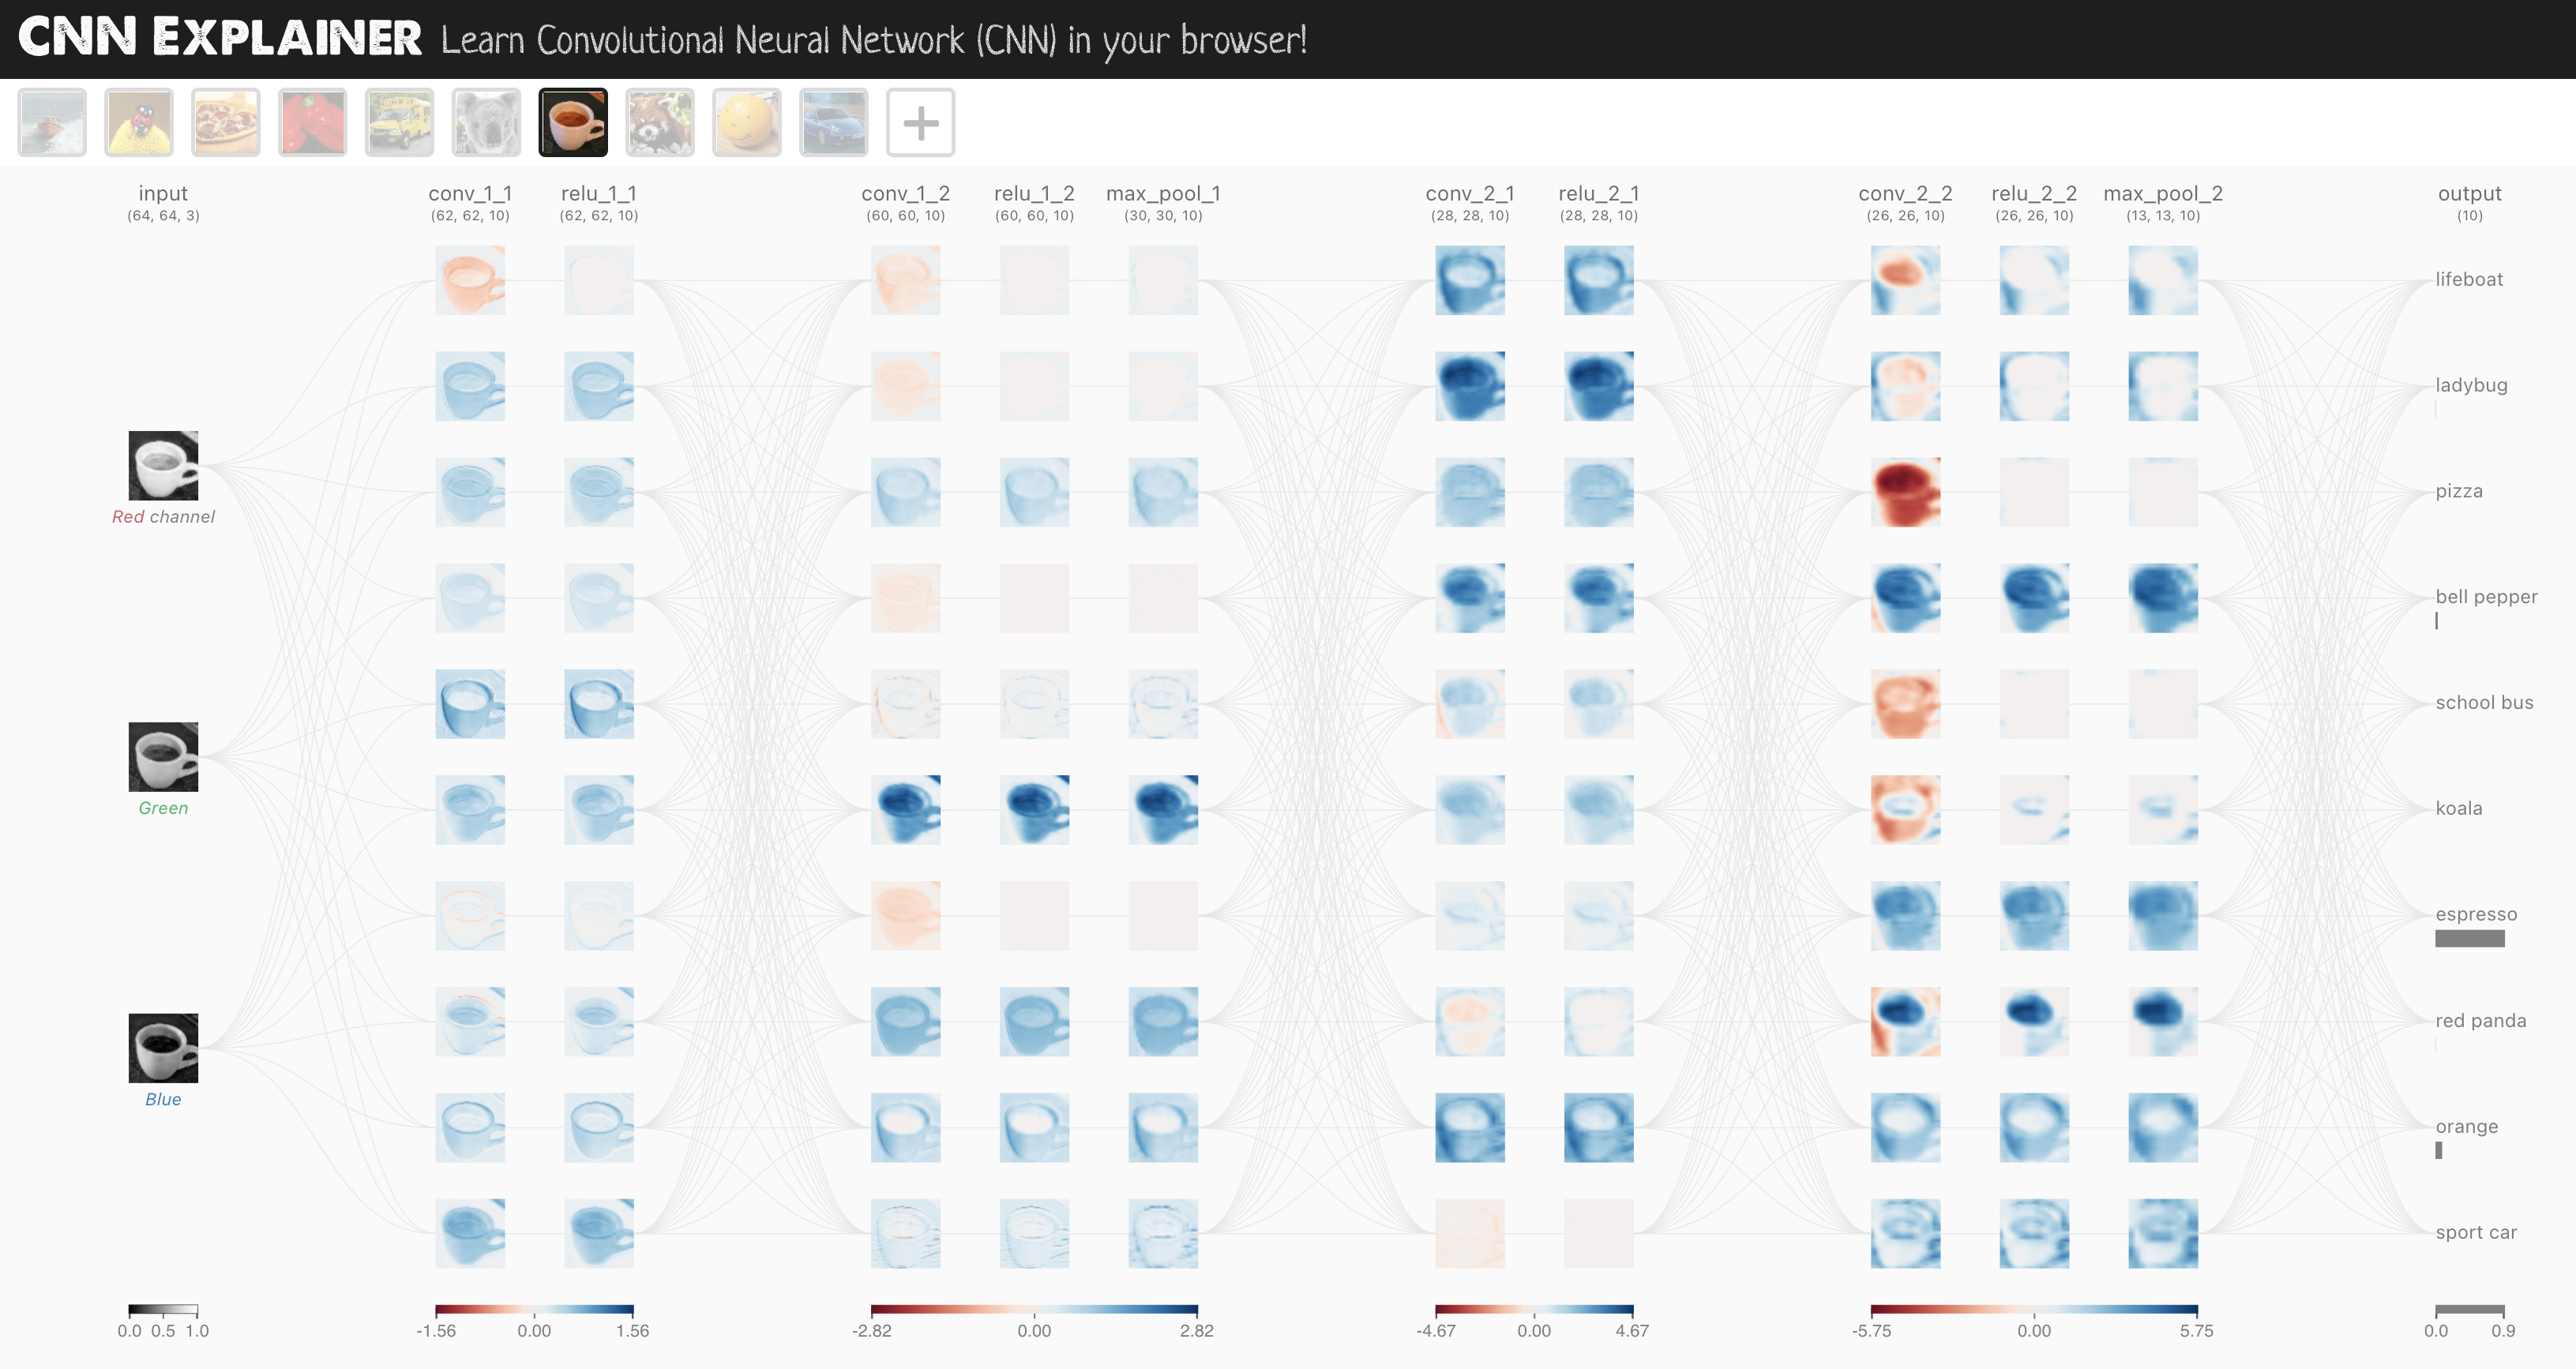

To do so, we'll leverage the [nn.Conv2d()]() and [nn.MaxPool2d()]() layers from `torch.nn`.

In [33]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Find a model architecture somewhere and replicate it with code.

### 7.1 Stepping through `nn.Conv2d()`


### 7.2 Stepping through `nn.MaxPool2d()`

### 7.3 Setup a loss function and optimizer for `model_2`

We'll use `nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification data).

And `torch.optim.SGD()` as the optimizer to optimize `model_2.parameters()` with a learning rate of `0.1`.

In [34]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 7.4 Training and testing `model_2 `using our training and test functions


We'll use our `train_step()` and `test_step()` functions.

`train_step()` function is for the training loop which takes in a model, a `DataLoader` a *loss function* and an *optimizer*.

The testing loop will be similar but it'll be called `test_step()` and it'll take in a model, a `DataLoader`, a *loss function* and an *evaluation function*.

> **Note:** Since these are functions, you can customize them in any way you like. What we're making here can be considered barebones training and testing functions for our specific classification use case.

In [35]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
               ):


    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # 2. Calcualte loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))   # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



def test_step(data_loader: torch.utils.data.dataloader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device
              ):

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)   # Go from logits -> pred labels
                                    )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



for helper function

In [39]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [40]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

In [43]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [44]:
# Import tqdm for progress bar
from tqdm.auto import tqdm


torch.manual_seed(42)

#Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------------")

    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )

    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device
                                            )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------------
Train loss: 0.30546 | Train accuracy: 88.87%
Test loss: 0.31997 | Test accuracy: 88.47%

Epoch: 1
------------
Train loss: 0.28938 | Train accuracy: 89.47%
Test loss: 0.31071 | Test accuracy: 88.60%

Epoch: 2
------------
Train loss: 0.27936 | Train accuracy: 89.83%
Test loss: 0.29529 | Test accuracy: 89.26%

Train time on cpu: 164.071 seconds


Let's evaluate `model_2`'s results with our `eval_model()` function.

In [45]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [47]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2952914237976074,
 'model_acc': 89.25718849840256}

### 9. Make and evaluate random predictions with best model

let's evaluate `model_2` model. To do so, let's create a function `make_predictions()` where we can pass the model and some data for it to predict on.


In [48]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [49]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


And now we can use our make_predictions() function to predict on test_samples.

In [50]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[3.2699e-09, 4.6954e-09, 5.9320e-09, 3.5190e-08, 1.1138e-08, 9.9996e-01,
         7.2328e-08, 3.2727e-06, 7.1580e-06, 2.5884e-05],
        [1.1620e-02, 9.6000e-01, 3.8208e-04, 1.1790e-02, 9.2202e-03, 2.0529e-05,
         6.7596e-03, 1.1999e-04, 3.2545e-05, 5.3494e-05]])

Now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.

In [51]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [52]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))


Now our predicted classes are in the same format as our test labels, we can compare.

Since we're dealing with image data, let's stay true to the data explorer's motto.

"Visualize, visualize, visualize!"

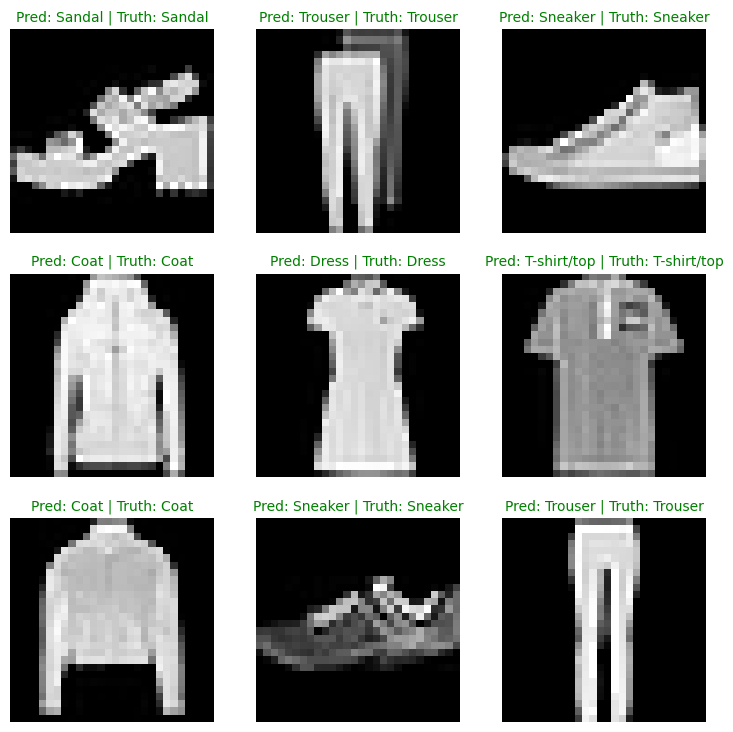

In [54]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Well, well, well, doesn't that look good!

Not bad for a couple dozen lines of PyTorch code!

### 10. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics]() we can use for classification problems.

One of the most visual is a [confusion matrix]().

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:


1.   Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2.   Make a confusion matrix using [torchmetrics.ConfusionMatrix]().
3. Plot the confusion matrix using [mlxtend.plotting.plot_confusion_matrix()](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Let's start by making predictions with our trained model.

In [55]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

 let's go through steps 2 & 3:

 First we'll need to make sure we've got `torchmetrics` and `mlxtend` installed (these two libraries will help us make and visual a confusion matrix).

 >  Note: If you're using Google Colab, the default version of `mlxtend` installed is 0.14.0 (as of March 2022), however, for the parameters of the `plot_confusion_matrix()` function we'd like use, we need 0.19.0 or higher.

In [56]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 14.2 MB/s eta 0:00:00
mlxtend version: 0.22.0


To plot the confusion matrix, we need to make sure we've got and mlxtend version of 0.19.0 or higher.

In [58]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


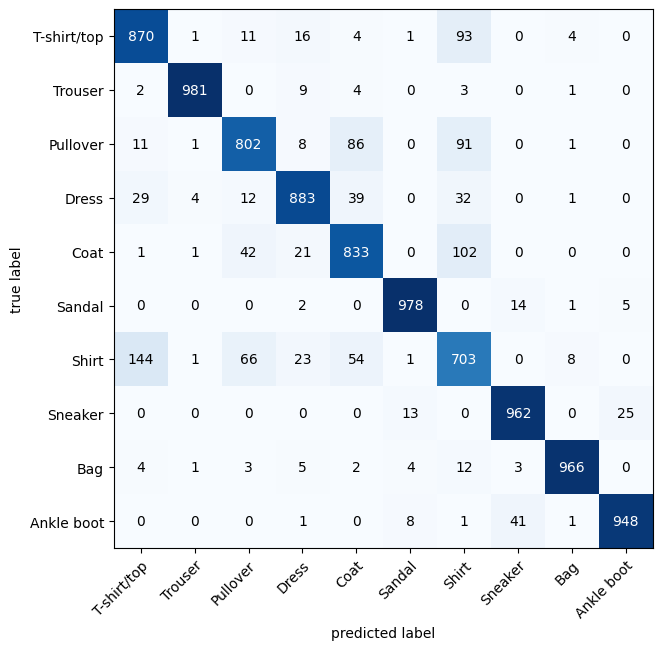

In [59]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


Woah! Doesn't that look good?

We can see our model does fairly well since most of the dark squares are down the diagonal from top left to bottom right (and ideal model will have only values in these squares and 0 everywhere else).

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

### 11. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

we can save and load a PyTorch model using a combination of:


*   `torch.save` - a function to save a whole PyTorch model or a model's `state_dict`().
*   `torch.load` - a function to load in a saved PyTorch object.
*   `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.


For now, let's save our `model_2`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.





In [60]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth



Now we've got a saved model `state_dict()` we can load it back in using a combination of `load_state_dict()` and `torch.load()`.

Since we're using `load_state_dict()`, we'll need to create a new instance of `FashionMNISTModelV2()` with the same input parameters as our saved model `state_dict()`.

In [61]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)


And now we've got a loaded model we can evaluate it with `eval_model()` to make sure its parameters work similarly to `model_2` prior to saving.

In [62]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2952914237976074,
 'model_acc': 89.25718849840256}

Do these results look the same as model_2_results?

In [63]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2952914237976074,
 'model_acc': 89.25718849840256}

We can find out if two tensors are close to each other using `torch.isclose()` and passing in a tolerance level of closeness via the parameters `atol` (absolute tolerance) and `rtol` (relative tolerance).

If our model's results are close, the output of `torch.isclose()` should be true.

In [64]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)